<a href="https://colab.research.google.com/github/pA1nD/course-deep-learning/blob/master/L5_Interpreting_Vision_Models_with_tf_explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting Deep Learning Models on Image Data

Here we will look at one of the newest frameworks (as on August, 2019) called `tf-explain` which offers a wide variety of techniques to explain vision based deep learning model predictions. [Real docs only in the code here.](https://github.com/sicara/tf-explain/tree/master/tf_explain/core)

Following are the techniques showcased in this notebook.

- Visualize Activation Layers
- Occlusion Sensitivity
- Grad-CAM
- SmoothGrad

# Install and Load Dependencies

In [0]:
!pip install tf-explain
!pip install pillow

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tf_explain.core.activations import ExtractActivations

     |████████████████████████████████| 51kB 3.8MB/s 
TensorFlow 2.x selected.


# Load pre-trained CNN - Xception Model

In [0]:
model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=True)
model.summary()

91889664/91884032 [==============================] - 2s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

# Make Model Prediction on Sample Image

--2020-01-10 01:01:42--  https://images.unsplash.com/photo-1527720255604-b27935ade401
Resolving images.unsplash.com (images.unsplash.com)... 151.101.54.208, 2a04:4e42:d::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.54.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9541996 (9.1M) [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg          100%[===================>]   9.10M  58.7MB/s    in 0.2s    

2020-01-10 01:01:43 (58.7 MB/s) - ‘image.jpeg’ saved [9541996/9541996]



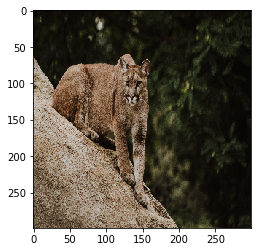

In [0]:
#@markdown Picture URL (*.jpeg format)
img_url = 'https://images.unsplash.com/photo-1527720255604-b27935ade401'  #@param {type: "string"}
!wget -O image.jpeg {img_url}

IMAGE_PATH = './image.jpeg'

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(299, 299))
img = tf.keras.preprocessing.image.img_to_array(img)

plt.imshow(img/255.)

Download imgnet map. Mapping classname and class id.
Here is how it looks:
```
[...]
 'bathtub': '435',
 'beach_wagon': '436',
 'beacon': '437',
 'beagle': '162',
 [...]
 ```

In [0]:
import requests

response = requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
imgnet_map = response.json()
imgnet_map = {v[1]: k for k, v in imgnet_map.items()}

Preprocess the image with the Model-custom xception.preprocess_input() function and run model.predict()

In [0]:
# This changes img as well! Run it only once. If run again, reinitialize img (cell above).
preprocessed_img = tf.keras.applications.xception.preprocess_input(img)

predictions = model.predict(np.array([preprocessed_img]))
decoded_predictions = tf.keras.applications.xception.decode_predictions(predictions, top=5)
print(decoded_predictions)

[[('n02125311', 'cougar', 0.7560136), ('n02127052', 'lynx', 0.036200646), ('n02129165', 'lion', 0.017224971), ('n02115913', 'dhole', 0.0059777764), ('n02128757', 'snow_leopard', 0.005447678)]]


# Interpretation with Activation Layer Visualizations

Visualize how a given input comes out of specific activation layers. Explores which feature maps are getting activated in the model.

In [0]:
explainerEA = ExtractActivations()

### Block 1

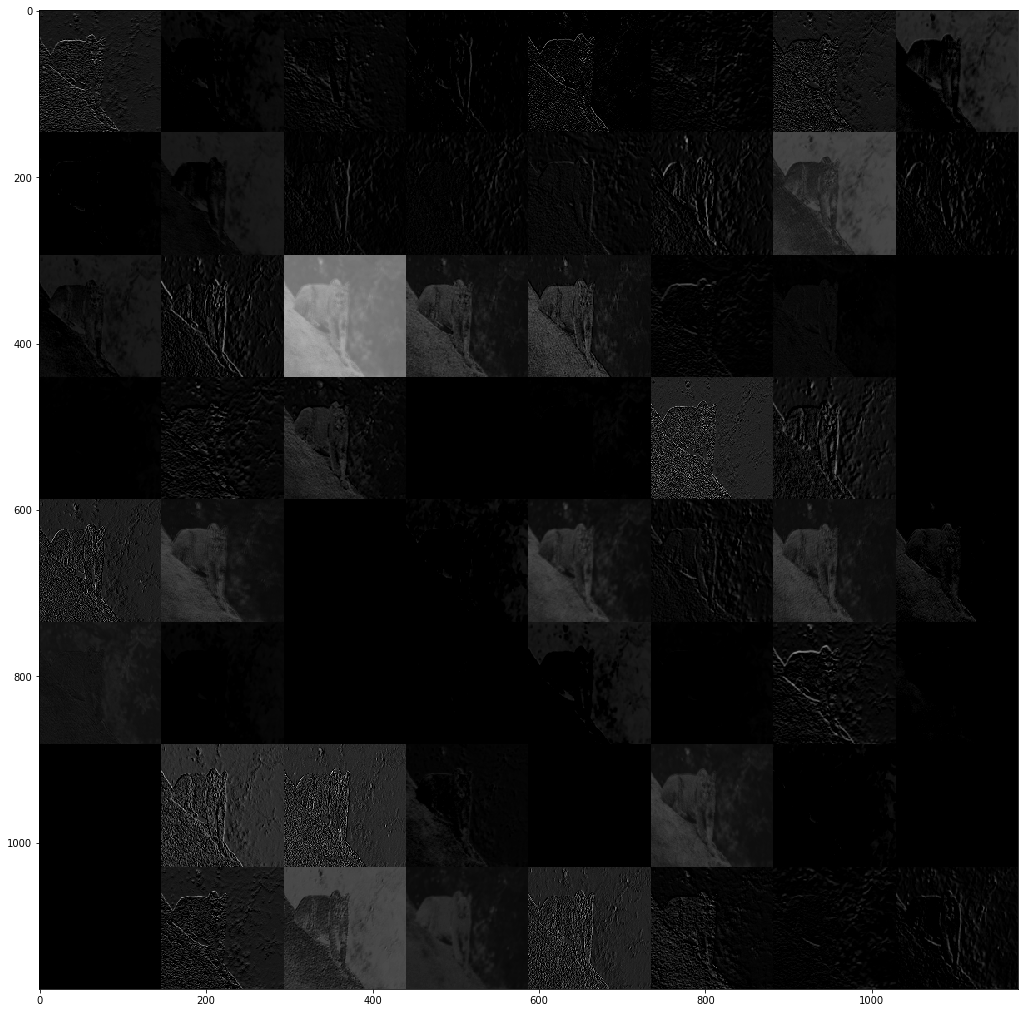

In [0]:
grid = explainerEA.explain((np.array([img]), None), model, ['block1_conv2_act'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

### Block 2

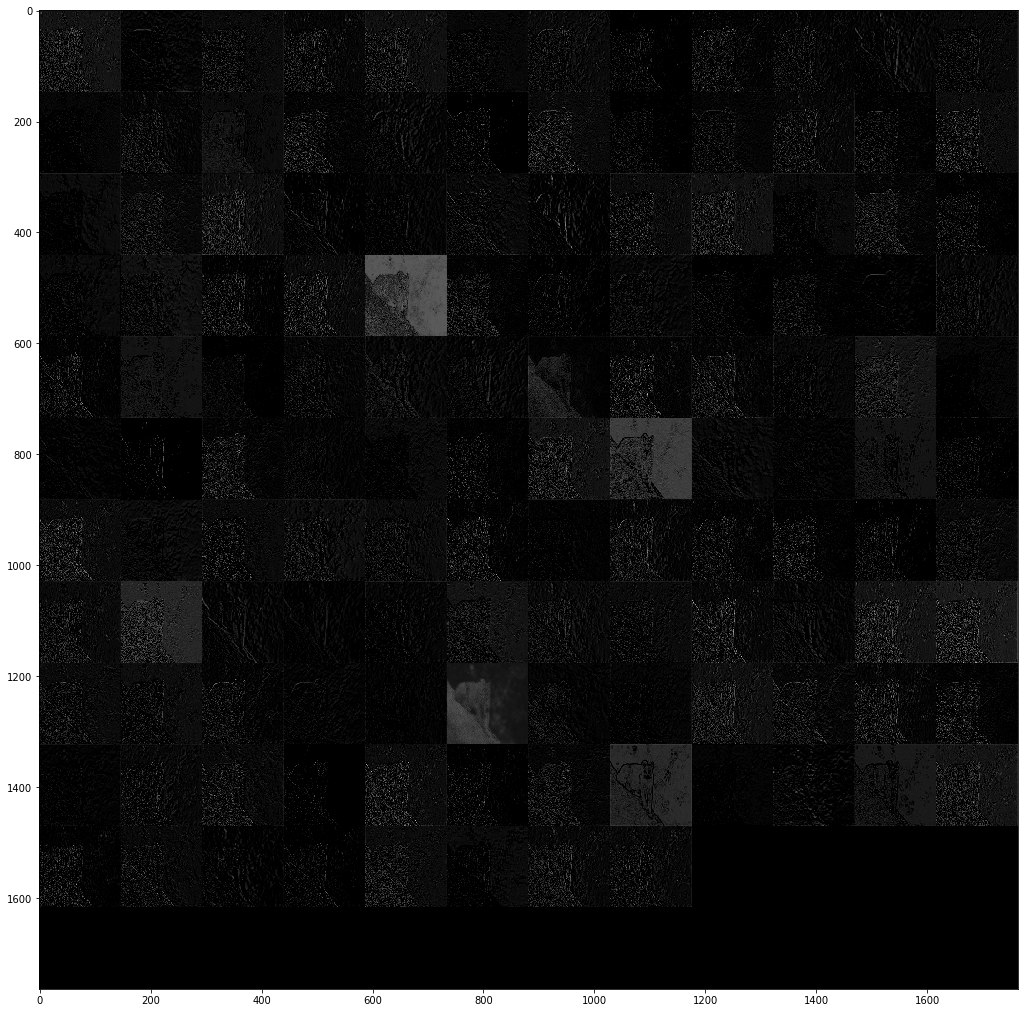

In [0]:
grid = explainerEA.explain((np.array([img]), None), model, ['block2_sepconv2_act'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

### Block 14

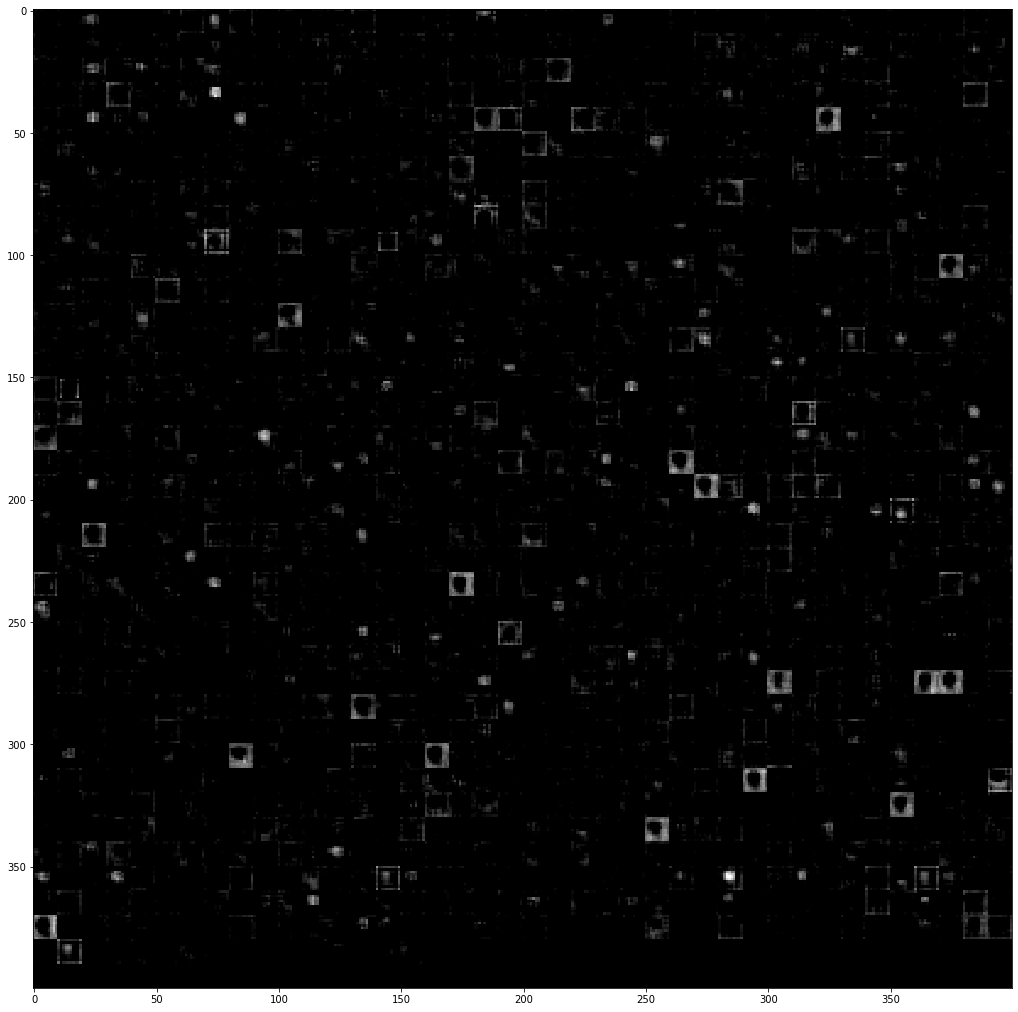

In [0]:
grid = explainerEA.explain((np.array([img]), None), model, ['block14_sepconv1_act'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

# Interpretation with Occlusion Sensitivity

Visualize how parts of the image affects neural network's confidence by occluding parts iteratively. Done by systematically occluding different portions of the
input image with a grey square, and monitoring the
output of the classifier. 

In [0]:
highest_prediction = decoded_predictions[0][0][1]

imgnet_map_class_number = imgnet_map[highest_prediction] #imgnet_map['Egyptian_cat']

[[('n02125311', 'cougar', 0.7560136),
  ('n02127052', 'lynx', 0.036200646),
  ('n02129165', 'lion', 0.017224971),
  ('n02115913', 'dhole', 0.0059777764),
  ('n02128757', 'snow_leopard', 0.005447678)]]

In [0]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

explainerOS = OcclusionSensitivity()

In [0]:
img_inp = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(299, 299))
img_inp = tf.keras.preprocessing.image.img_to_array(img_inp)

In [0]:
grid = explainerOS.explain(([img_inp], None), model, 286, 7)

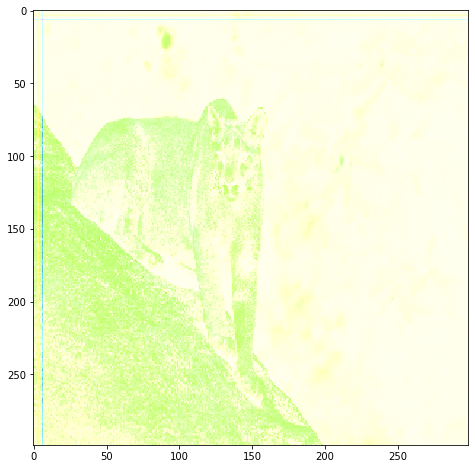

In [0]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(grid)#, alpha=1)

# Interpretation with GradCAM

Visualize how parts of the image affects neural network's output by looking into the class activation maps. Class activation maps are a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. In other words, a class activation map (CAM) lets us see which regions in the image were relevant to this class.

- The output of grad-cam will be pixels that contribute to the maximization of a target function. If for example you are interested in what maximizes category number 285, then zero out all the other categories.
- Compute the gradients of the target function, with respect to the convolutional layer outputs. This can be done effeciently with backpropagation

Given an image and a class of interest (e.g., ‘tiger cat’ or any other type of differentiable output) as input, we forward propagate the image through the CNN part of the model and then through task-specific computations to obtain a raw score for the category. 

The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the rectified convolutional feature maps of interest, which we combine to compute the coarse Grad-CAM localization (blue heatmap) which represents where the model has to look to make the particular decision

In [0]:
from tf_explain.core.grad_cam import GradCAM

In [0]:
explainerGCAM = GradCAM()

In [0]:
first_prediction = decoded_predictions[0][0][1] # highest prediction
second_prediction = decoded_predictions[0][1][1] # second higheset prediction

imgnet_class_index_first = int(imgnet_map[first_prediction]) #explainerGCAM.explain(class_index=...) wants int
imgnet_class_index_second = int(imgnet_map[second_prediction])
print("first place:", first_prediction, ". id:", imgnet_class_index_first)
print("second place:", second_prediction, ". id:", imgnet_class_index_second)

first place: cougar . id: 286
second place: lynx . id: 287


## Block 1

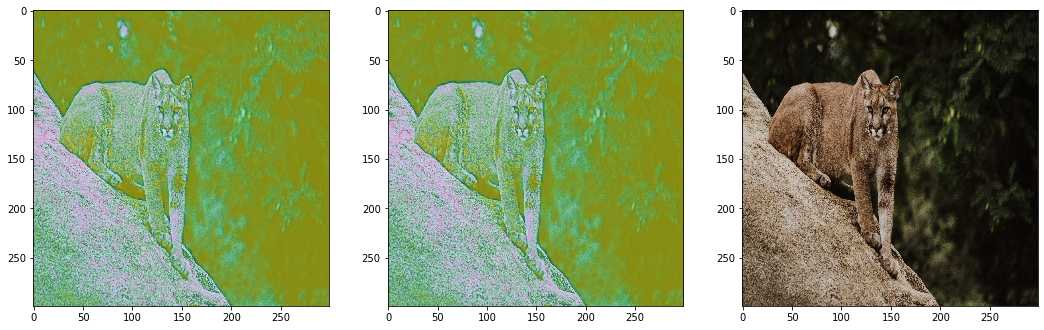

In [0]:
grid1 = explainerGCAM.explain(([img], None), model, layer_name="block1_conv1", class_index=imgnet_class_index_first)
grid2 = explainerGCAM.explain(([img], None), model, layer_name='block1_conv1', class_index=imgnet_class_index_second)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

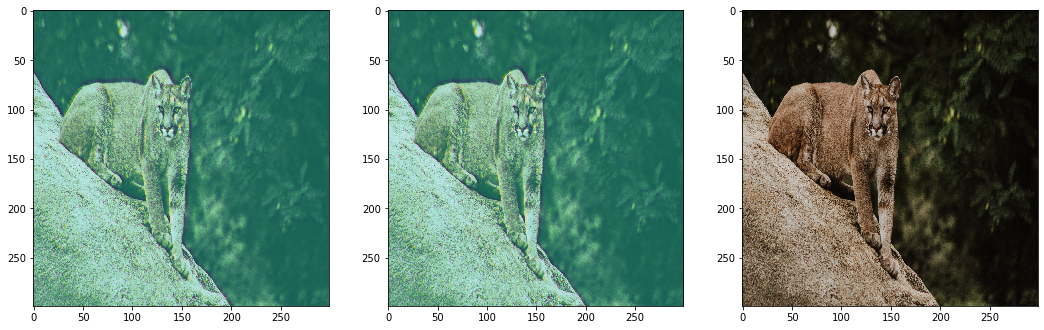

In [0]:
grid1 = explainerGCAM.explain(([img], None), model, layer_name='block1_conv2', class_index=imgnet_class_index_first)
grid2 = explainerGCAM.explain(([img], None), model, layer_name='block1_conv2', class_index=imgnet_class_index_second)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

## Block 6

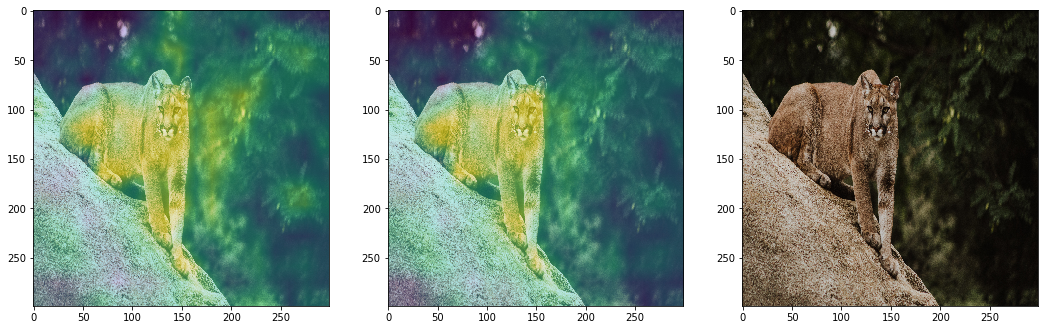

In [0]:
grid1 = explainerGCAM.explain(([img], None), model, layer_name='block6_sepconv1', class_index=imgnet_class_index_first)
grid2 = explainerGCAM.explain(([img], None), model, layer_name='block6_sepconv1', class_index=imgnet_class_index_second)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

## Block 9

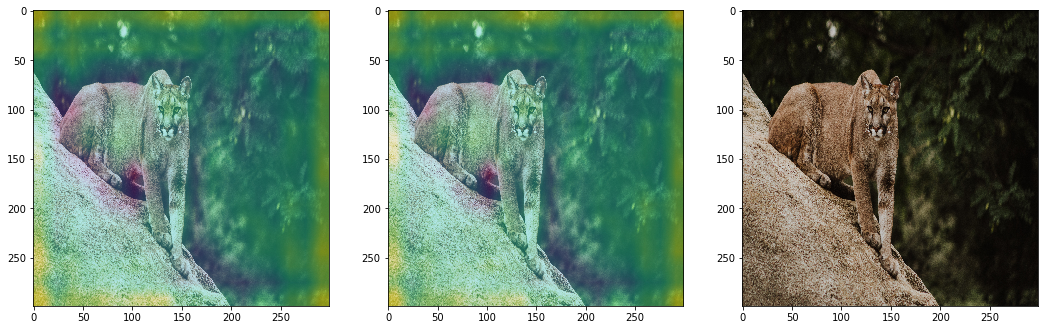

In [0]:
grid1 = explainerGCAM.explain(([img], None), model, layer_name='block9_sepconv1', class_index=imgnet_class_index_first)
grid2 = explainerGCAM.explain(([img], None), model, layer_name='block9_sepconv1', class_index=imgnet_class_index_second)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

## Block 12

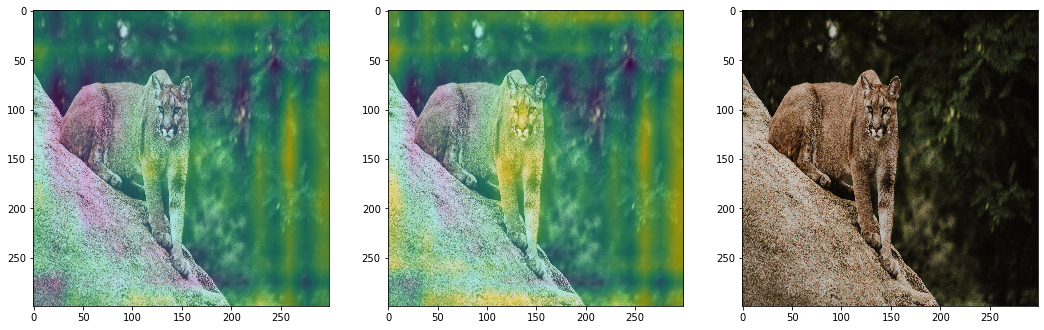

In [0]:
grid1 = explainerGCAM.explain(([img], None), model, layer_name='block12_sepconv1', class_index=imgnet_class_index_first)
grid2 = explainerGCAM.explain(([img], None), model, layer_name='block12_sepconv1', class_index=imgnet_class_index_second)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

## Block 14

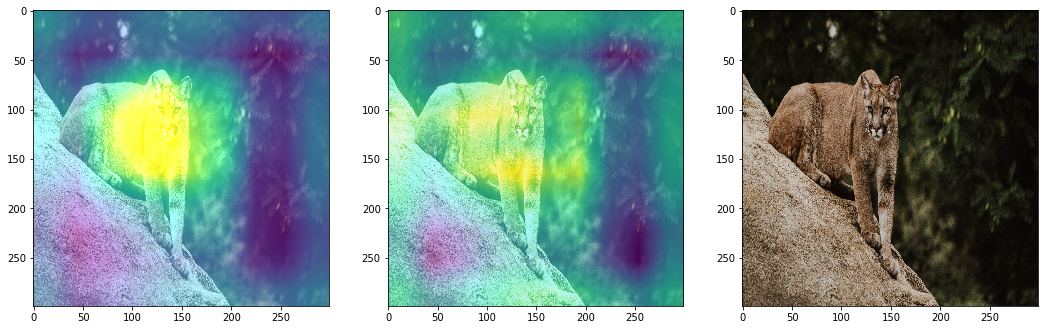

In [0]:
grid1 = explainerGCAM.explain(([img], None), model, layer_name='block14_sepconv1', class_index=imgnet_class_index_first)
grid2 = explainerGCAM.explain(([img], None), model, layer_name='block14_sepconv1', class_index=imgnet_class_index_second)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=1)


ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.9)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

# Interpretation with SmoothGrad

Visualize stabilized gradients on the inputs towards the decision. Identify pixels that strongly influence the final decision. 

A starting point for this strategy is the gradient of the class score function with respect to the input image. This gradient can be interpreted as a sensitivity map, and there are several techniques that elaborate on this basic idea. 

SmoothGrad is a simple method that can help visually sharpen gradient-based sensitivity maps.

The core idea is to take an image of interest, sample similar images by adding noise to the image, then take
the average of the resulting sensitivity maps for each sampled image.

In [0]:
from tf_explain.core.smoothgrad import SmoothGrad

explainerSG = SmoothGrad()

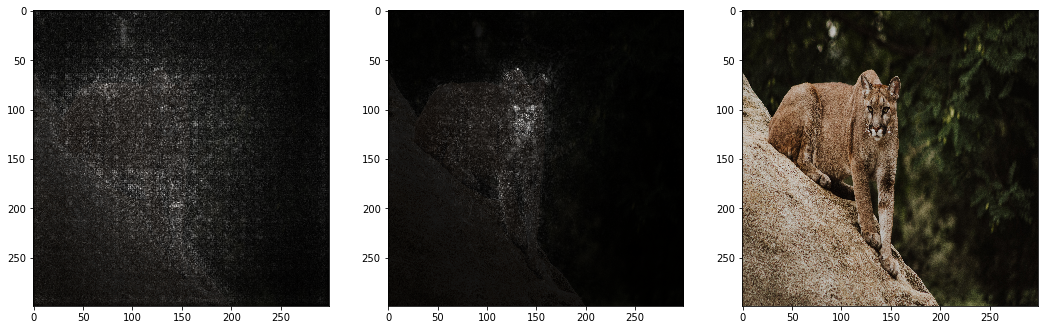

In [0]:
grid1 = explainerSG.explain(([img], None), model, imgnet_class_index_first, 80, .2) # 80 is max on GPUs
grid2 = explainerSG.explain(([img], None), model, imgnet_class_index_second, 80, .2)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.9, cmap='binary_r')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.9, cmap='binary_r')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

# License

Copyright 2019 SICARA and 2020 Björn Schmidtke for GSERM.

In [0]:
#@title MIT License

# Copyright (c) 2019 SICARA
# Copyright (c) 2020 Björn Schmidtke

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.